# Data set comparison

The aim of this note book is to compare different annotations of a same piece using the different metrics developped : the binary, SPS, voice leading and tone by tone metrics.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast

from glob import glob
from fractions import Fraction
from math import *

import sys
sys.path.append('/home/xavier/Documents/dcml/python_scripts')

from metric import get_distance
from progression import get_progression, plot_comparison
from data_types import ChordType,PitchType
from constants import TRIAD_REDUCTION
from utils import get_chord_pitches

## Beethoven sonatas annotaions comparison

Here two set of annotations of the first movement of Beethoven sonatas are compared : the dcml and the fh annotations.

In [5]:
sonata = pd.read_csv('../Data/sonata_comparisons.csv', converters={'number': str})
sonata.set_index('number', inplace = True)

sonata['avg_sps_normalized'] = (sonata['average_sps']-np.mean(sonata['average_sps']))/np.std(sonata['average_sps'])
sonata['avg_vl_normalized'] = (sonata['average_vl']-np.mean(sonata['average_vl']))/np.std(sonata['average_vl'])
sonata['avg_tbt_normalized'] = (sonata['average_tbt']-np.mean(sonata['average_tbt']))/np.std(sonata['average_tbt'])
sonata['avg_bin_normalized'] = (sonata['average_bin']-np.mean(sonata['average_bin']))/np.std(sonata['average_bin'])

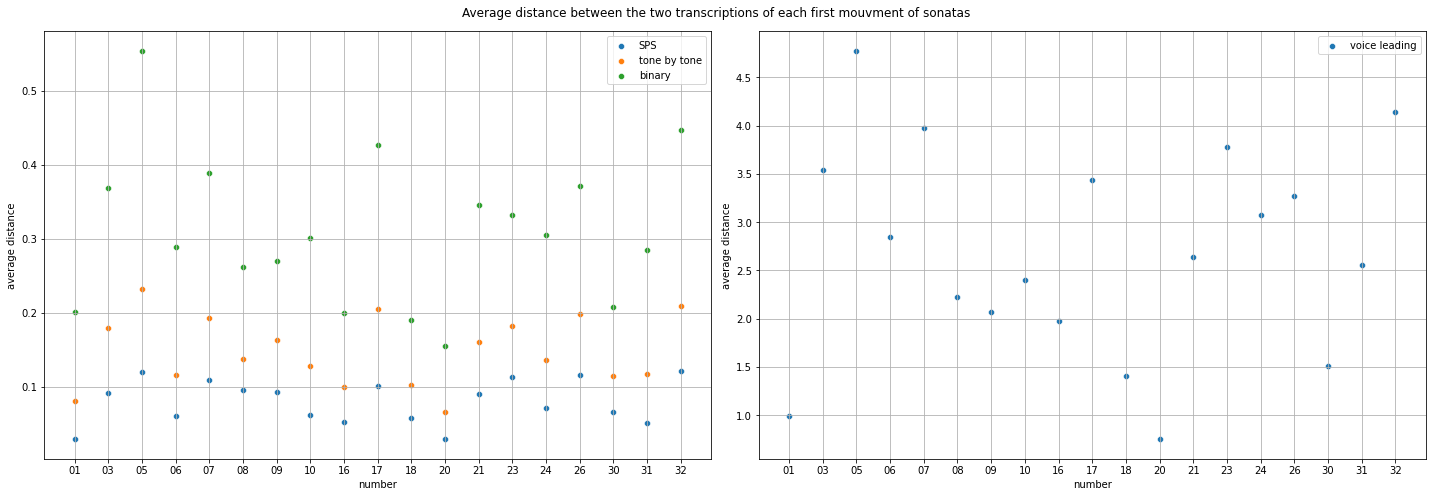

In [6]:
fig, axs = plt.subplots(1,2,figsize=(20,7))

sns.scatterplot(data=sonata, x='number', y='average_sps',ax=axs[0], label='SPS')
sns.scatterplot(data=sonata, x='number', y='average_tbt',ax=axs[0], label='tone by tone')
sns.scatterplot(data=sonata, x='number', y='average_bin',ax=axs[0], label='binary')
sns.scatterplot(data=sonata, x='number', y='average_vl',ax=axs[1], label='voice leading')
axs[0].grid()
axs[0].set(xlabel='number', ylabel='average distance')
axs[1].grid()
axs[1].set(xlabel='number', ylabel='average distance')


fig.suptitle('Average distance between the two transcriptions of each first mouvment of sonatas');
fig.tight_layout()

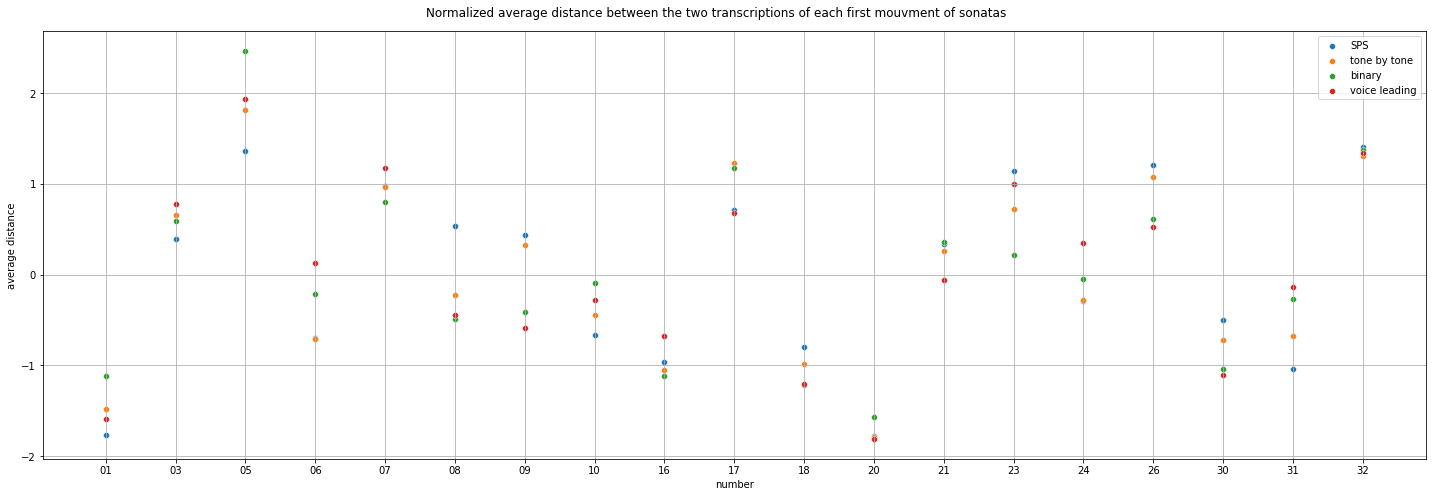

In [16]:
fig, axs = plt.subplots(1,1,figsize=(20,7))

sns.scatterplot(data=sonata, x='number', y='avg_sps_normalized',ax=axs, label='SPS')
sns.scatterplot(data=sonata, x='number', y='avg_tbt_normalized',ax=axs, label='tone by tone')
sns.scatterplot(data=sonata, x='number', y='avg_bin_normalized',ax=axs, label='binary')
sns.scatterplot(data=sonata, x='number', y='avg_vl_normalized',ax=axs, label='voice leading')
axs.grid()
axs.set(xlabel='number', ylabel='average distance')


fig.suptitle('Normalized average distance between the two transcriptions of each first mouvment of sonatas');
fig.tight_layout()

___

## Discrepancies visualization

One can visualize the discrepancies between two annotations of a given piece. The x-axis represents the time and is given in whole note.

In [8]:
nb = 20
nb = str(nb) 
nb = nb if len(nb)>1 else '0'+ nb 
fh_path =  '../Data/Beethoven_sonata_fh/' + nb + '-1.csv'
dcml_path =  '../Data/Beethoven_sonata_dcml/' + nb + '-1.csv'

PITCH_TO_STRING = {0:'C',1:'Db',2:'D',3:'Eb',4:'E',5:'F',
                   6:'Gb',7:'G',8:'Ab',9:'A',10:'Bb',11:'B'}

fh_df = pd.read_csv(fh_path, converters={'duration': Fraction})
fh_df['chord_type'] = fh_df['chord_type'].apply(lambda r : ChordType[r.split(".")[1]])
fh_df['full_chord'] = fh_df.apply(lambda r : PITCH_TO_STRING[r.chord_root_midi] + '_' + str(r.chord_type).split(".")[1]+"_inv"+str(r.chord_inversion), axis=1)    

features = ['interval', 'matched_idx', 'matched_duration', 'chords_sps_dist', 'chords_vl_dist', 'chords_tbt_dist']
for feature in features :
    fh_df[feature] = fh_df[feature].apply(lambda r : ast.literal_eval(r))
    
dcml_df = pd.read_csv(dcml_path, converters={'duration': Fraction})
dcml_df['chord_type'] = dcml_df['chord_type'].apply(lambda r : ChordType[r.split(".")[1]])
dcml_df['full_chord'] = dcml_df.apply(lambda r : PITCH_TO_STRING[r.chord_root_midi] + '_' + str(r.chord_type).split(".")[1]+"_inv"+str(r.chord_inversion), axis=1)    
dcml_df['interval'] = dcml_df['interval'].apply(lambda r : ast.literal_eval(r))

progression =  pd.read_csv('../Data/Beethoven_sonata_progression/' + nb + '-1.csv')


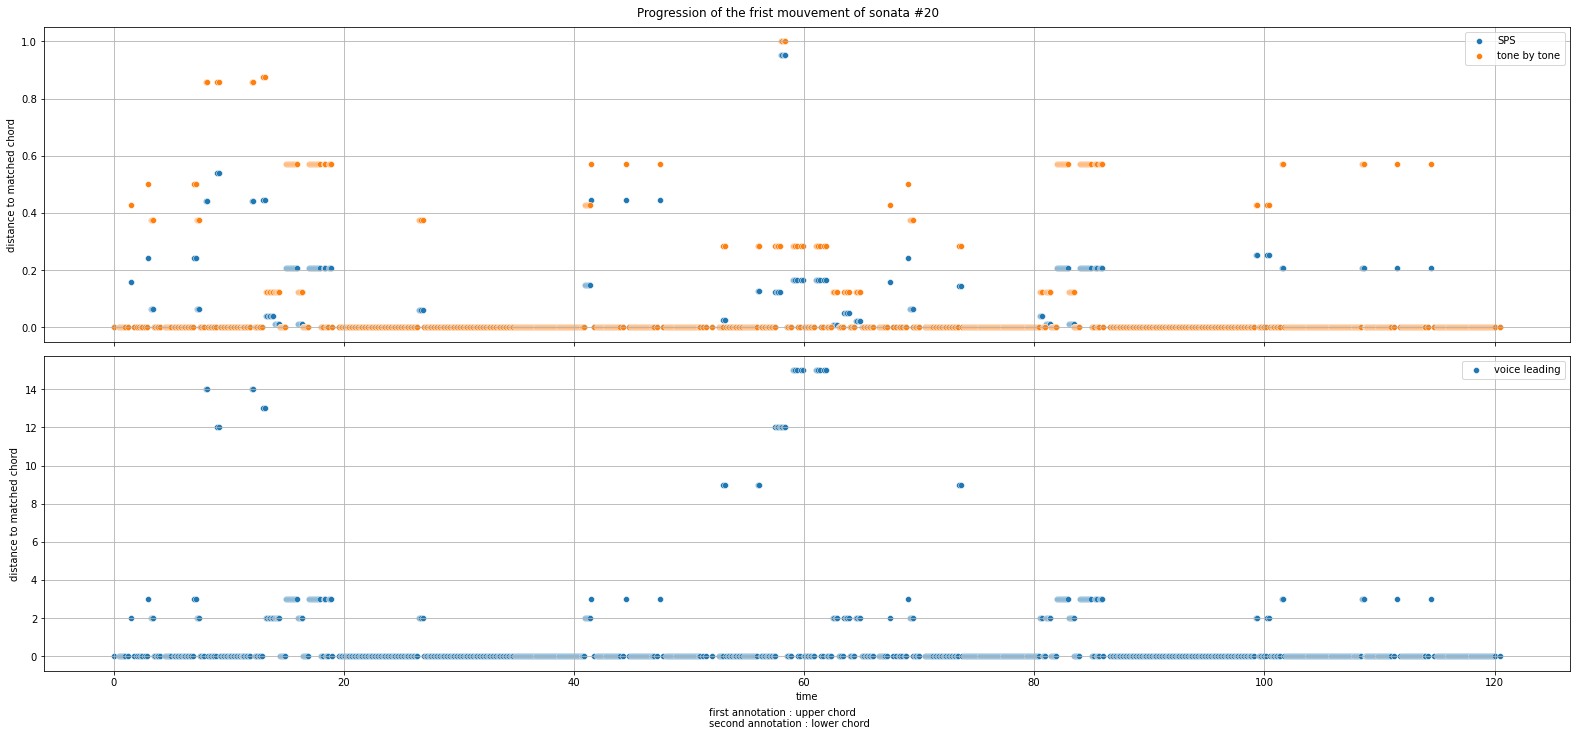

In [9]:
title = 'Progression of the frist mouvement of sonata #'+nb
plot_comparison(progression=progression, title=title)

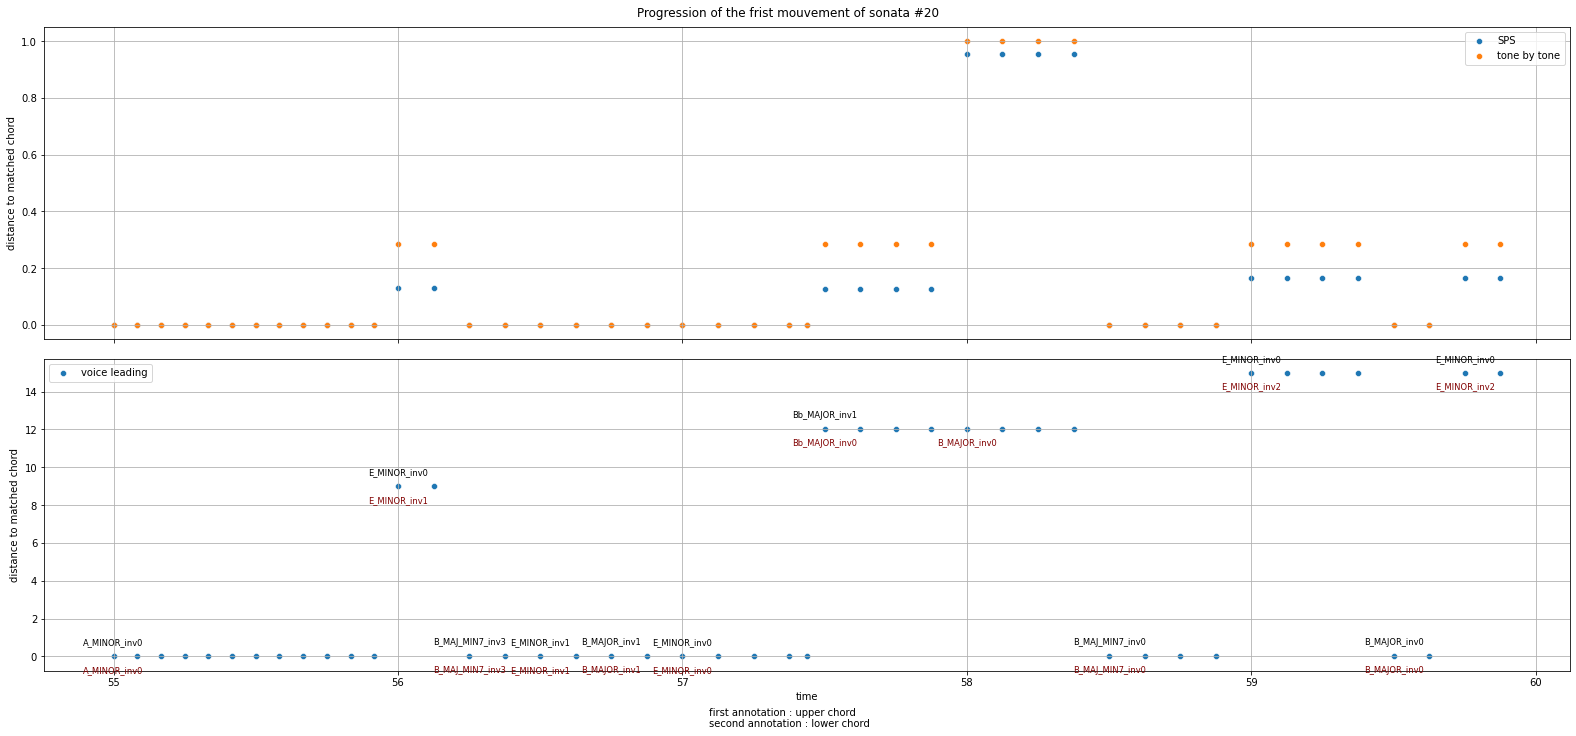

In [10]:
plot_comparison(progression=progression,rge=[55,60], verbose=True, title=title)

___

## Automatic chord evaluation comparison

Here different data set of an automatic chord evaluation algorithm are compared with a given ground truth annotaion. The different outputs are obtained with different input parameter values.

In [11]:
corpus_df_p25 = pd.read_csv("../Data/chord-eval/25/corpus.csv")
corpus_df_p30 = pd.read_csv("../Data/chord-eval/30/corpus.csv")
corpus_df_p40 = pd.read_csv("../Data/chord-eval/40/corpus.csv")
corpus_df_p50 = pd.read_csv("../Data/chord-eval/50/corpus.csv")
corpus_df_p75 = pd.read_csv("../Data/chord-eval/75/corpus.csv")
corpus_df_p100 = pd.read_csv("../Data/chord-eval/100/corpus.csv")
corpus_df_p150 = pd.read_csv("../Data/chord-eval/150/corpus.csv")

for corpus_df in [corpus_df_p25, corpus_df_p30, corpus_df_p40, corpus_df_p50, corpus_df_p75, corpus_df_p100, corpus_df_p150]:
    
    corpus_df['sps_accuracy'] = corpus_df['average_sps'].apply(lambda sps :1-sps)
    corpus_df['vl_accuracy'] = corpus_df['average_vl'].apply(lambda vl :1-vl)
    corpus_df['tbt_accuracy'] = corpus_df['average_tbt'].apply(lambda tbt :1-tbt)
    corpus_df['average_bin'] = corpus_df['binary_accuracy'].apply(lambda b :1-b)
    corpus_df['parameter'] = corpus_df['path'].apply(lambda p: p.split('/')[3])

    corpus_df['avg_sps_normalized'] = (corpus_df['average_sps']-np.mean(corpus_df['average_sps']))/np.std(corpus_df['average_sps'])
    corpus_df['avg_vl_normalized'] = (corpus_df['average_vl']-np.mean(corpus_df['average_vl']))/np.std(corpus_df['average_vl'])
    corpus_df['avg_tbt_normalized'] = (corpus_df['average_tbt']-np.mean(corpus_df['average_tbt']))/np.std(corpus_df['average_tbt'])
    corpus_df['avg_bin_normalized'] = (corpus_df['average_bin']-np.mean(corpus_df['average_bin']))/np.std(corpus_df['average_bin'])

In [12]:
corpus_df = pd.concat([pd.concat([pd.concat([corpus_df_p25,corpus_df_p30], ignore_index=True),
                                  pd.concat([corpus_df_p40,corpus_df_p50], ignore_index=True)],
                                  ignore_index=True),
                       pd.concat([pd.concat([corpus_df_p75,corpus_df_p100], ignore_index=True),
                                  corpus_df_p150],ignore_index=True)],
                      ignore_index=True)


In [13]:
corpus_df_l = pd.concat([corpus_df[['name', 'parameter']],corpus_df[['name', 'parameter']]], ignore_index=True)
                      
                     

corpus_df_l['dist'] = pd.concat([corpus_df['average_bin'],corpus_df['average_sps']], ignore_index=True)
                               

corpus_df_l['dist_normalized'] = pd.concat([corpus_df['avg_bin_normalized'],corpus_df['avg_sps_normalized']], ignore_index=True)

corpus_df_l['accuracy'] = pd.concat([corpus_df['binary_accuracy'],corpus_df['sps_accuracy']], ignore_index=True)

corpus_df_l['metric'] = pd.Series(['binary']*56 + ['SPS']*56)
corpus_df_l

,name,parameter,dist,dist_normalized,accuracy,metric
0,K576-1,25,0.385016,0.590377,0.614984,binary
1,K332-3,25,0.311565,-0.486756,0.688435,binary
2,K279-2,25,0.336712,-0.117982,0.663288,binary
3,K545-3,25,0.251701,-1.364639,0.748299,binary
4,K310-2,25,0.344595,-0.002383,0.655405,binary
...,...,...,...,...,...,...
107,K545-3,150,0.060295,-1.077752,0.939705,SPS
108,K310-2,150,0.082506,-0.454351,0.917494,SPS
109,K284-1,150,0.174548,2.129007,0.825452,SPS
110,K331-1,150,0.075278,-0.657219,0.924722,SPS


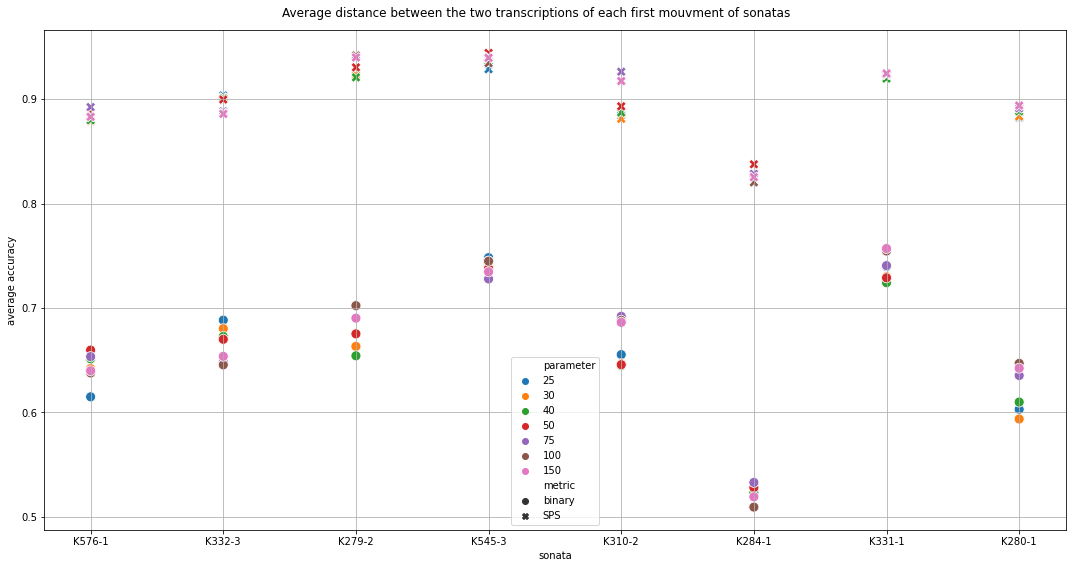

In [17]:
fig, axs = plt.subplots(1,1,figsize=(15,8))

sns.scatterplot(data=corpus_df_l, x='name', y='accuracy', hue='parameter', style='metric', s=100)
axs.grid()
axs.set(xlabel='sonata', ylabel='average accuracy')
axs.legend(loc='lower center')

fig.suptitle('Average distance between the two transcriptions of each first mouvment of sonatas');
fig.tight_layout()

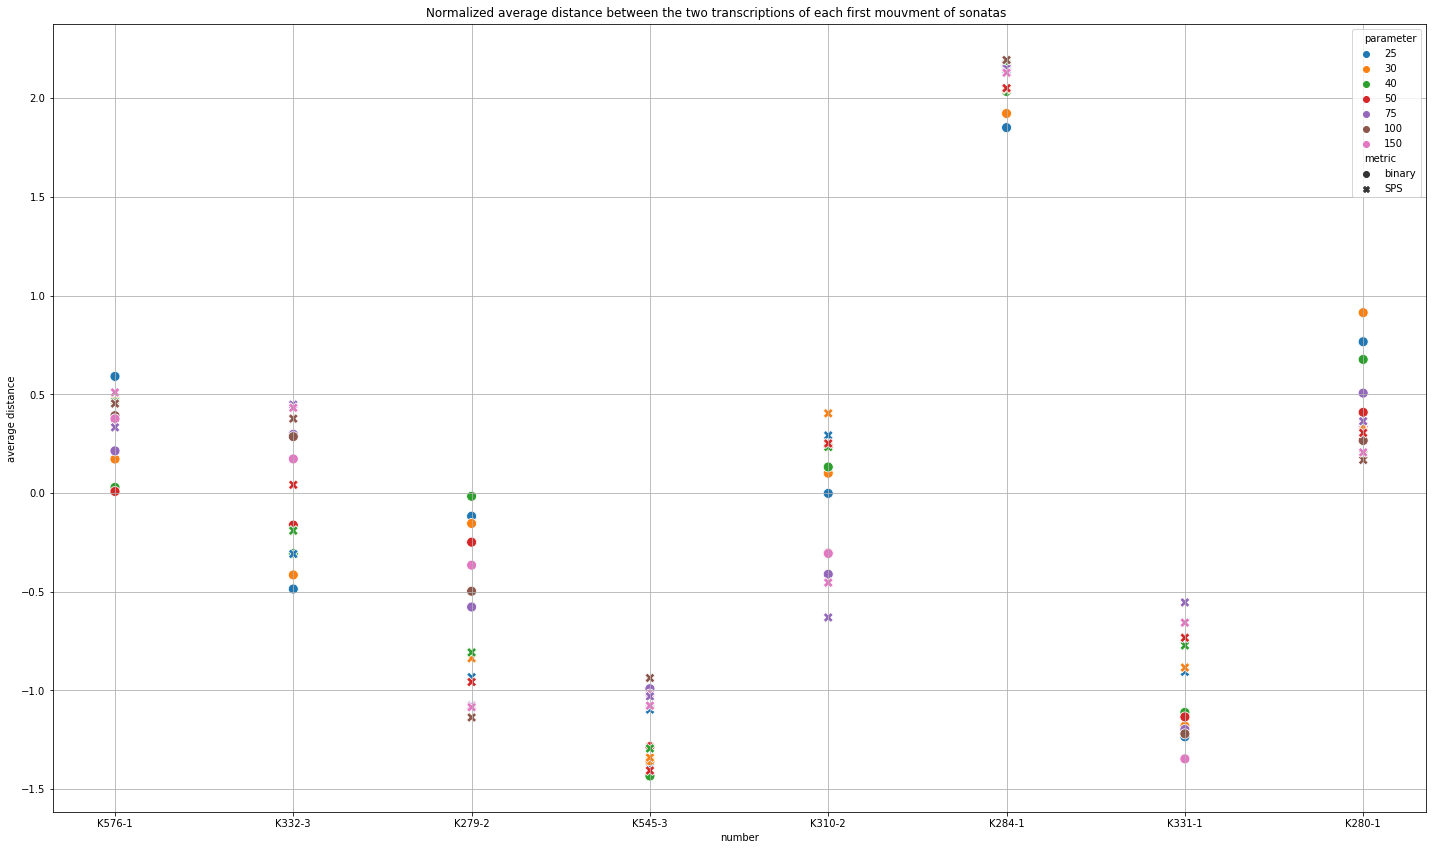

In [18]:
fig, axs = plt.subplots(1,1,figsize=(20,12))

sns.scatterplot(data=corpus_df_l, x='name', y='dist_normalized', hue='parameter', style='metric', s=100)
axs.grid()
axs.set(xlabel='number', ylabel='average distance')

fig.suptitle('Normalized average distance between the two transcriptions of each first mouvment of sonatas');
fig.tight_layout()

In [63]:
for idx, df in corpus_df_l.groupby(['name', 'metric']):
    print(idx, df.accuracy.std())

('K279-2', 'SPS') 0.00940967049362445
('K279-2', 'binary') 0.019724691432986056
('K280-1', 'SPS') 0.004814006989828086
('K280-1', 'binary') 0.02113127150868695
('K284-1', 'SPS') 0.005373944715546467
('K284-1', 'binary') 0.007923657726024
('K310-2', 'SPS') 0.01862660308662727
('K310-2', 'binary') 0.022094600518349956
('K331-1', 'SPS') 0.0017826882686271582
('K331-1', 'binary') 0.012697843499083596
('K332-3', 'SPS') 0.007849675072170346
('K332-3', 'binary') 0.016579005631110855
('K545-3', 'SPS') 0.005093220225580473
('K545-3', 'binary') 0.007041485299411785
('K576-1', 'SPS') 0.004930577369672898
('K576-1', 'binary') 0.014614097895990044


In [62]:
corpus_df_l.groupby(['metric']).std()

,dist,dist_normalized,accuracy
metric,,,
SPS,0.034333,1.00905,0.034333
binary,0.066675,1.00905,0.066675
